# Simulate acoustic wave propagation on a sphere


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook showcases the basic functionality to perform acoustic simulations. The simulation consists of an incident plane wave in an unbounded water region and a spherical scatterer resembling bone.


## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


## Specify the physical settings for the simulation

The OptimUS library provides functionality to simulate acoustic wave propagation. For each simulation, one needs to specify the type of source of the acoustic field, the geometry of the scatterer, and the material parameters.

The OptimUS library provides different predefined wave fields, among which a plane wave. The plane wave requires the frequency to be specified and, optionally, the wave direction.

In [4]:
frequency = 1000
source = optimus.source.create_planewave(frequency)

Several canonical shapes for scatterers are available in the OptimUS library. Let us use a spherical geometry, by default centered at the origin and unit radius. It is recommended to specify the meshwidth of the triangular surface grid that represents the geometry's surface. A lower value of `h` increases the precision of the algorithm but also the computational costs.

In [5]:
geometry = optimus.geometry.shapes.Sphere(h=0.4)

To see the table of material database and pick the correct tissue name use:

In [6]:
df = optimus.material.common.get_material_database()

In [7]:
# df.style.set_properties(**{'border': '1.3px solid green',
#                           'color': 'black'})

The exterior medium will be water and the interior medium bone. Default parameters of several materials can be retrieved from OptimUS. Alternatively, the user can create a material with specific values for density and wavespeed. 

In [8]:
material_ext = optimus.material.load_material('FaT')
material_int = optimus.material.load_material('Vertebrae')

##### In the case of multiple domains, a list of materials should be passed to the load_material function above. Input argument to the load_material function is case insensitive.

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. A model with default settings can be used. Alternatively, other boundary integral formulations and preconditioners can be chosen or specified manually.

Each model requires a source and geometry object, as well as the material parameters of the unbounded exterior domain and the bounded interior domain.

In [9]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

In [10]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [11]:
import numpy as np
import bempp.api
from matplotlib import pylab as plt

In [12]:
# Create a visualisation grid
Nx = 100
Ny = 100
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

# Define the interior and exterior points
x, y = points[:2]
idx_ext = np.sqrt(x**2 + y**2) > 1.0
idx_int = np.logical_not(idx_ext)
points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

In [13]:
# Calculate the fields from the surface potential with the potential operators
slp_pot_int = bempp.api.operators.potential.helmholtz.single_layer(
    model.space, points_interior, material_int.compute_wavenumber(source.frequency))
slp_pot_ext = bempp.api.operators.potential.helmholtz.single_layer(
    model.space, points_exterior, material_ext.compute_wavenumber(source.frequency))
dlp_pot_int = bempp.api.operators.potential.helmholtz.double_layer(
    model.space, points_interior, material_int.compute_wavenumber(source.frequency))
dlp_pot_ext = bempp.api.operators.potential.helmholtz.double_layer(
    model.space, points_exterior, material_ext.compute_wavenumber(source.frequency))

surfpot_dir_ext, surfpot_neu_ext = model.solution
surfpot_dir_int = surfpot_dir_ext
surfpot_neu_int = (material_int.density / material_ext.density) * surfpot_neu_ext
total_field_int = (slp_pot_int * surfpot_neu_int
                   - dlp_pot_int * surfpot_dir_int).ravel()
total_field_ext = (dlp_pot_ext * surfpot_dir_ext 
                   - slp_pot_ext * surfpot_neu_ext).ravel() \
    + np.exp(1j * material_ext.compute_wavenumber(source.frequency) * points_exterior[0])

total_field = np.zeros(points.shape[1], dtype='complex128')
total_field[idx_ext] = total_field_ext
total_field[idx_int] = total_field_int
total_field = total_field.reshape([Nx, Ny])

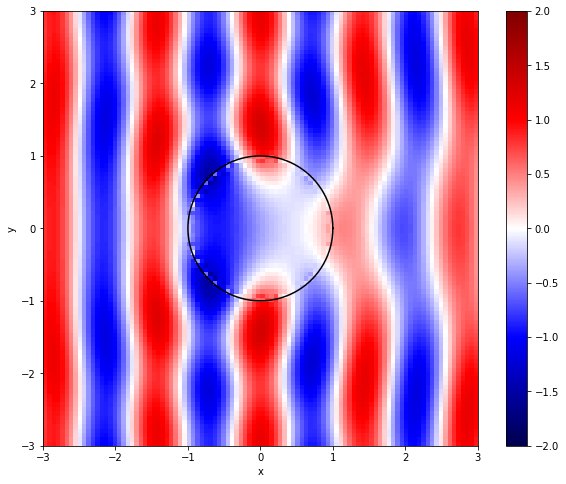

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(total_field.T), extent=[xmin, xmax, ymin, ymax], clim=[-2,2], cmap='seismic')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [15]:
properties = {
    "name": 'test',
    "density": 100,
    "speed_of_sound": 1000,
    "attenuation_coeff_a": 1,
    "attenuation_pow_b": 2,
}

In [16]:
mat = optimus.material.create_material(properties)

In [17]:
# def write_material_database(properties):
#     dataframe = read_database(sheet="user-defined")
#     dataframe.append(
#         {
#             ("Tissue", "Name"): properties["name"],
#             ("Density (kg/m3)", "Average"): properties["density"],
#             ("Speed of Sound [m/s]", "Average"): properties["speed_of_sound"],
#             ("Attenuation Constant", "a [Np/m/MHz]"): properties["attenuation_coeff_a"],
#             ("Attenuation Constant", "b"): properties["attenuation_pow_b"],
#         },
#         ignore_index=True,
#     )

#     dataframe.to_excel("../optimus/material/Material_database-user-defined.xls", sheet_name="user-defined")

In [18]:
# write_material_database(properties)

In [19]:
# def read_database(sheet="default"):
#     dataframe = pd.read_excel("../optimus/material/Material_database.xls", sheet_name=sheet, header=[0, 1])
#     return dataframe

In [20]:
# import os
# import pandas as pd

In [21]:
# print(os.path.dirname(__file__))

In [22]:
mat.compute_wavenumber(1000)

(6.283185307179586+1e-06j)

In [35]:
df1 = df.copy()

In [36]:
df1.append(
        {
            ("Tissue", "Name"): properties["name"],
            ("Density (kg/m3)", "Average"): properties["density"],
            ("Speed of Sound [m/s]", "Average"): properties["speed_of_sound"],
            ("Attenuation Constant", "a [Np/m/MHz]"): properties["attenuation_coeff_a"],
            ("Attenuation Constant", "b"): properties["attenuation_pow_b"],
        },
        ignore_index=True,
    )

Tissue Density (kg/m3) Speed of Sound [m/s]  \
                      Name         Average              Average   
0            Adrenal Gland      928.000000          1500.000000   
1                      Air        1.164092           343.000000   
2                     Bile      928.000000          1500.000000   
3                    Blood     1049.750000          1578.183333   
4             Blood Plasma     1020.050000          1549.350000   
5              Blood Serum     1024.000000          1500.000000   
6        Blood Vessel Wall     1101.500000          1569.142857   
7        Bone (Cancellous)     1178.333333          2117.533333   
8          Bone (Cortical)     1908.000000          3514.857143   
9        Bone Marrow (Red)     1028.500000          1450.000000   
10    Bone Marrow (Yellow)      980.000000          1371.910000   
11                   Brain     1045.500000          1546.323529   
12     Brain (Grey Matter)     1044.500000          1500.000000   
13    Brain (White Matter)     1041.000000          1552.500000   
14              Breast Fat      911.000000          1440.187500   
15            Breast Gland     1040.500000          1505.000000   
16                 Bronchi     1101.500000          1569.142857   
17           Bronchi lumen        1.164092           343.000000   
18               Cartilage     1099.500000          1639.600000   
19              Cerebellum     1045.000000          1537.000000   
20     Cerebrospinal Fluid     1007.000000          1504.500000   
21                  Cervix     1104.500000          1629.000000   
22     Commissura Anterior     1041.000000          1552.500000   
23    Commissura Posterior     1041.000000          1552.500000   
24       Connective Tissue     1026.500000          1545.000000   
25               Diaphragm     1090.400000          1588.430556   
26         Ductus Deferens     1101.500000          1569.142857   
27                    Dura     1174.000000          1500.000000   
28              Epididymis     1082.000000          1595.000000   
29               Esophagus     1040.000000          1500.000000   
..                     ...             ...                  ...   
83         Seminal vesicle     1045.000000          1559.500000   
84                    Skin     1109.000000          1624.000000   
85                   Skull     1908.000000          2770.350000   
86        Skull Cancellous     1178.333333          2117.533333   
87          Skull Cortical     1908.000000          2813.692308   
88         Small Intestine     1030.000000          1500.000000   
89   Small Intestine Lumen     1045.200000          1535.365278   
90             Spinal Cord     1075.000000          1542.000000   
91                  Spleen     1089.000000          1567.600000   
92                 Stomach     1088.000000          1500.000000   
93           Stomach Lumen     1045.200000          1535.365278   
94         Tendon\Ligament     1142.000000          1750.000000   
95                  Testis     1082.000000          1595.000000   
96                Thalamus     1044.500000          1500.000000   
97                  Thymus     1023.000000          1513.093750   
98           Thyroid Gland     1050.000000          1500.000000   
99                  Tongue     1090.400000          1588.430556   
100                  Tooth     2180.000000          4565.878205   
101        Tooth (Dentine)     2063.000000          3639.833333   
102         Tooth (Enamel)     2958.333333          5491.923077   
103                Trachea     1080.000000          1639.600000   
104          Trachea Lumen        1.164092           343.000000   
105         Ureter\Urethra     1101.500000          1569.142857   
106   Urinary Bladder Wall     1086.000000          1500.000000   
107                  Urine     1023.613204          1537.666667   
108                 Uterus     1104.500000          1629.000000   
109                 Vagina     1088.000000          1500.000000   


In [33]:
import pandas as pd
database_file = "../optimus/material/Material_database-user-defined.xls"

In [37]:
with pd.ExcelWriter(database_file) as writer:
    df1.to_excel(writer)  